In [1]:
import pandas as pd
import datetime
import numpy as np

#from pandas.tseries import offsets
#from dateutil.relativedelta import relativedelta


In [2]:
customers = pd.read_csv("assessment_customers.csv")
all_subs = pd.read_csv("assessment_subscriptions.csv")
charges = pd.read_csv("assessment_charges.csv")

In [3]:
customers_df = pd.DataFrame(customers)
subscriptions_df = pd.DataFrame(all_subs)
charges_df = pd.DataFrame(charges)

In [4]:
# Create a timestamp to keep help determine the length of the active subscriptions
timestamp = (datetime.datetime(2023, 2, 23))
time_stamp = timestamp.today()
today = time_stamp.strftime('%m/%d/%y %H:%M')
today

'02/28/23 10:25'

In [5]:
# Replace the null values of the "last_active_month" column with "today" date values
# for only rows with null values for "cancelled_at", fill them with 0. Later we can select all CANCELLED status rows that do not lack a cancelled_at date.
# The CANCELLED status rows with missing "cancelled_at" dates will be voided in this assessment.
subscriptions_df.loc[subscriptions_df['status'] == 'CANCELLED', "cancelled_at"]= subscriptions_df.loc[subscriptions_df['status'] == 'CANCELLED', "cancelled_at"].fillna(0)
# Create a "last_active_month" column that contains an upper limit for the calculation of each active subscription's duration
subscriptions_df["last_active_month"] = subscriptions_df["cancelled_at"]
# Replace the null values of the "last_active_month" column with "today" date values. This will only replace the null values in the "ACTIVE" status rows.
subscriptions_df["last_active_month"] = subscriptions_df["last_active_month"].fillna(today)

In [6]:
# Create a column called "sub_revenue/month" which tracks the amount of revenue each subscription brings

subscriptions_df["sub_revenue/month"] = subscriptions_df["recurring_price"]*subscriptions_df["quantity"]

In [7]:
# This dataframe will server as parental. It contains all ACTIVE and STATUS subs in the calculations with our conditions.
subscriptions_df=subscriptions_df.loc[(subscriptions_df["status"]=='ACTIVE')|(subscriptions_df["cancelled_at"]!=0)]

In [8]:
# convert the datatype of these columns to datetime.
subscriptions_df['created_at'] = pd.to_datetime(subscriptions_df['created_at'])
subscriptions_df['last_active_month'] = pd.to_datetime(subscriptions_df['last_active_month'])

In [9]:
subscriptions_df.dtypes

subscription_id               int64
customer_id                   int64
address_id                    int64
status                       object
product_title                object
recurring_price             float64
quantity                      int64
created_at           datetime64[ns]
cancelled_at                 object
last_active_month    datetime64[ns]
sub_revenue/month           float64
dtype: object

In [10]:
def create_active_months_list(start_date, end_date):
    return pd.period_range(start_date, end_date, freq='M').to_list()

v_create_active_months_list = np.vectorize(create_active_months_list, otypes=[object])

subscriptions_df['active_months'] = v_create_active_months_list(subscriptions_df['created_at'], subscriptions_df['last_active_month'])

# Subtract last index position element of list if the length of the list of the range of dates is greater than 1
mask = subscriptions_df['active_months'].apply(len) > 1
subscriptions_df.loc[mask, 'active_months'] = subscriptions_df.loc[mask, 'active_months'].apply(lambda x: x[:-1])

In [11]:
subscriptions_df

,subscription_id,customer_id,address_id,status,product_title,recurring_price,quantity,created_at,cancelled_at,last_active_month,sub_revenue/month,active_months
0,155517507,65434304,69830954,CANCELLED,Adrenal Super Tonic,26.78,1,2021-05-21 16:18:00,7/26/21 18:40,2021-07-26 18:40:00,26.78,"[2021-05, 2021-06]"
1,155517510,65434304,69830954,CANCELLED,Activated Charcoal,22.05,1,2021-05-21 16:18:00,7/26/21 18:40,2021-07-26 18:40:00,22.05,"[2021-05, 2021-06]"
2,155517518,65434304,69830954,CANCELLED,Golden Mind,26.25,1,2021-05-21 16:18:00,7/26/21 18:40,2021-07-26 18:40:00,26.25,"[2021-05, 2021-06]"
3,155517524,65434304,69830954,CANCELLED,Elderberry Defense,22.05,1,2021-05-21 16:18:00,7/26/21 18:40,2021-07-26 18:40:00,22.05,"[2021-05, 2021-06]"
4,155517525,65434304,69830954,CANCELLED,Longevity Mushrooms,25.20,1,2021-05-21 16:18:00,7/26/21 18:40,2021-07-26 18:40:00,25.20,"[2021-05, 2021-06]"
...,...,...,...,...,...,...,...,...,...,...,...,...
339020,335171272,106388353,116607381,ACTIVE,Adrenal Super Tonic,40.60,1,2023-02-20 14:50:00,NaN,2023-02-28 10:25:00,40.60,[2023-02]
339021,335171273,106388353,116607381,ACTIVE,Magnesium L-Threonate,47.60,1,2023-02-20 14:50:00,NaN,2023-02-28 10:25:00,47.60,[2023-02]
339022,335171274,106388353,116607381,ACTIVE,Liposomal Glutathione,61.60,1,2023-02-20 14:50:00,NaN,2023-02-28 10:25:00,61.60,[2023-02]
339023,335171275,106388353,116607381,ACTIVE,Mineral Shilajit,46.90,1,2023-02-20 14:50:00,NaN,2023-02-28 10:25:00,46.90,[2023-02]


In [12]:
subscription_revenue_history = subscriptions_df.explode('active_months')

In [13]:
subscription_revenue_history

,subscription_id,customer_id,address_id,status,product_title,recurring_price,quantity,created_at,cancelled_at,last_active_month,sub_revenue/month,active_months
0,155517507,65434304,69830954,CANCELLED,Adrenal Super Tonic,26.78,1,2021-05-21 16:18:00,7/26/21 18:40,2021-07-26 18:40:00,26.78,2021-05
0,155517507,65434304,69830954,CANCELLED,Adrenal Super Tonic,26.78,1,2021-05-21 16:18:00,7/26/21 18:40,2021-07-26 18:40:00,26.78,2021-06
1,155517510,65434304,69830954,CANCELLED,Activated Charcoal,22.05,1,2021-05-21 16:18:00,7/26/21 18:40,2021-07-26 18:40:00,22.05,2021-05
1,155517510,65434304,69830954,CANCELLED,Activated Charcoal,22.05,1,2021-05-21 16:18:00,7/26/21 18:40,2021-07-26 18:40:00,22.05,2021-06
2,155517518,65434304,69830954,CANCELLED,Golden Mind,26.25,1,2021-05-21 16:18:00,7/26/21 18:40,2021-07-26 18:40:00,26.25,2021-05
...,...,...,...,...,...,...,...,...,...,...,...,...
339020,335171272,106388353,116607381,ACTIVE,Adrenal Super Tonic,40.60,1,2023-02-20 14:50:00,NaN,2023-02-28 10:25:00,40.60,2023-02
339021,335171273,106388353,116607381,ACTIVE,Magnesium L-Threonate,47.60,1,2023-02-20 14:50:00,NaN,2023-02-28 10:25:00,47.60,2023-02
339022,335171274,106388353,116607381,ACTIVE,Liposomal Glutathione,61.60,1,2023-02-20 14:50:00,NaN,2023-02-28 10:25:00,61.60,2023-02
339023,335171275,106388353,116607381,ACTIVE,Mineral Shilajit,46.90,1,2023-02-20 14:50:00,NaN,2023-02-28 10:25:00,46.90,2023-02


In [14]:
# To get the monthly revenue, group the above dataframe "history_of_all_subscriptions" by active_month and sum the (sub_revenue/month)
revenue_calculation =subscription_revenue_history.copy()
revenue_per_month = revenue_calculation.groupby("active_months").sum()[["sub_revenue/month"]]


In [15]:
revenue_per_month

,sub_revenue/month
active_months,
2021-05,73525.30
2021-06,2319464.60
2021-07,2181383.06
2021-08,941167.52
2021-09,789645.15
2021-10,781633.43
2021-11,941197.41
2021-12,948865.46
2022-01,1184970.67


In [16]:
# Make a table that shows the starting subscription revenue and ending subscription revenue for each month.
revenue_per_month.insert(loc=revenue_per_month.columns.get_loc("sub_revenue/month")+1, column="ending_subscription_revenue", value=revenue_per_month["sub_revenue/month"].shift(-1))


In [17]:
revenue_per_month = revenue_per_month.rename(columns={"sub_revenue/month":"starting_subscription_revenue"})

In [18]:
# MoM Revenue Growth Rate is calculated by taking one month's revenue and dividing it by the previous month's total revenue. The, subtract 1 from the quotient and multiple by 100 to
# get the percentage.
revenue_per_month["MoM_Growth_Rate (%)"]= 100*(revenue_per_month["ending_subscription_revenue"]/revenue_per_month["starting_subscription_revenue"]-1)

In [19]:
revenue_per_month

,starting_subscription_revenue,ending_subscription_revenue,MoM_Growth_Rate (%)
active_months,,,
2021-05,73525.30,2319464.60,3054.648264
2021-06,2319464.60,2181383.06,-5.953164
2021-07,2181383.06,941167.52,-56.854551
2021-08,941167.52,789645.15,-16.099405
2021-09,789645.15,781633.43,-1.014598
2021-10,781633.43,941197.41,20.414170
2021-11,941197.41,948865.46,0.814712
2021-12,948865.46,1184970.67,24.882896
2022-01,1184970.67,1254997.66,5.909597


In [20]:
# I eliminated the 3 rows with either null values or growth rates that were too extreme to highlight the MoM changes through the established years.
revenue_per_month = revenue_per_month.iloc[1:-2]

In [21]:
revenue_per_month.to_csv("start_and_end_sub_revenue.csv")
revenue_per_month

,starting_subscription_revenue,ending_subscription_revenue,MoM_Growth_Rate (%)
active_months,,,
2021-06,2319464.60,2181383.06,-5.953164
2021-07,2181383.06,941167.52,-56.854551
2021-08,941167.52,789645.15,-16.099405
2021-09,789645.15,781633.43,-1.014598
2021-10,781633.43,941197.41,20.414170
2021-11,941197.41,948865.46,0.814712
2021-12,948865.46,1184970.67,24.882896
2022-01,1184970.67,1254997.66,5.909597
2022-02,1254997.66,1517826.29,20.942559


In [22]:
import matplotlib.pyplot as plt
y_max = int(revenue_per_month["MoM_Growth_Rate (%)"].max())
y_min = int(revenue_per_month["MoM_Growth_Rate (%)"].min())
yticks = [round(x/5)*5 for x in np.arange(y_min,y_max,5)]


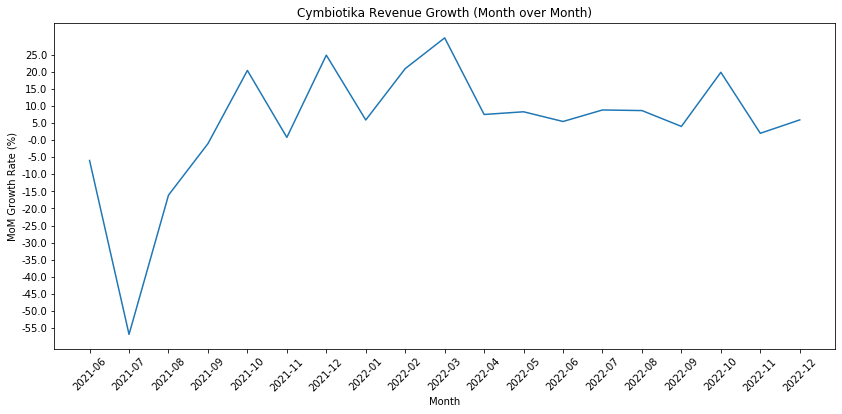

In [23]:
xticks = [str(x) for x in revenue_per_month.index]
fig, ax = plt.subplots()
ax.plot(xticks,revenue_per_month["MoM_Growth_Rate (%)"])
fig.set_size_inches(14,6)
ax.set_title("Cymbiotika Revenue Growth (Month over Month)")
ax.set_xlabel("Month")
ax.set_ylabel("MoM Growth Rate (%)")
new_ticks = yticks
ax.set_yticks(new_ticks)      
ax.set_yticklabels([str(x) for x in yticks])
plt.xticks(rotation=45)
plt.show()